In [129]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import link_bot_notebooks.toy_problem_optimization_common as tpoc
import open3d as o3d
import numpy as np
import copy
from time import time

np.set_printoptions(suppress=True, linewidth=200, precision=2)
plt.style.use('slides')

In [2]:
data=np.load("./data/250_50_sdf_based_collision.npz")
# data=np.load("./data/10000_50_collision.npz")

In [3]:
sdf_data = np.load("./data/obstacles_1_sdf.npz")
res = np.expand_dims(sdf_data['sdf_resolution'], axis=1)
sdf = sdf_data['sdf'].squeeze()
origin = np.expand_dims(np.array(sdf.shape, dtype=np.int32) / 2, axis=1)

In [4]:
actions = data['actions']
states = data['states']
tail = data['states'][:, :, 0:2]
mid = data['states'][:, :, 2:4]
head = data['states'][:, :, 4:6]
constraints = data['constraints']
T = states.shape[1]

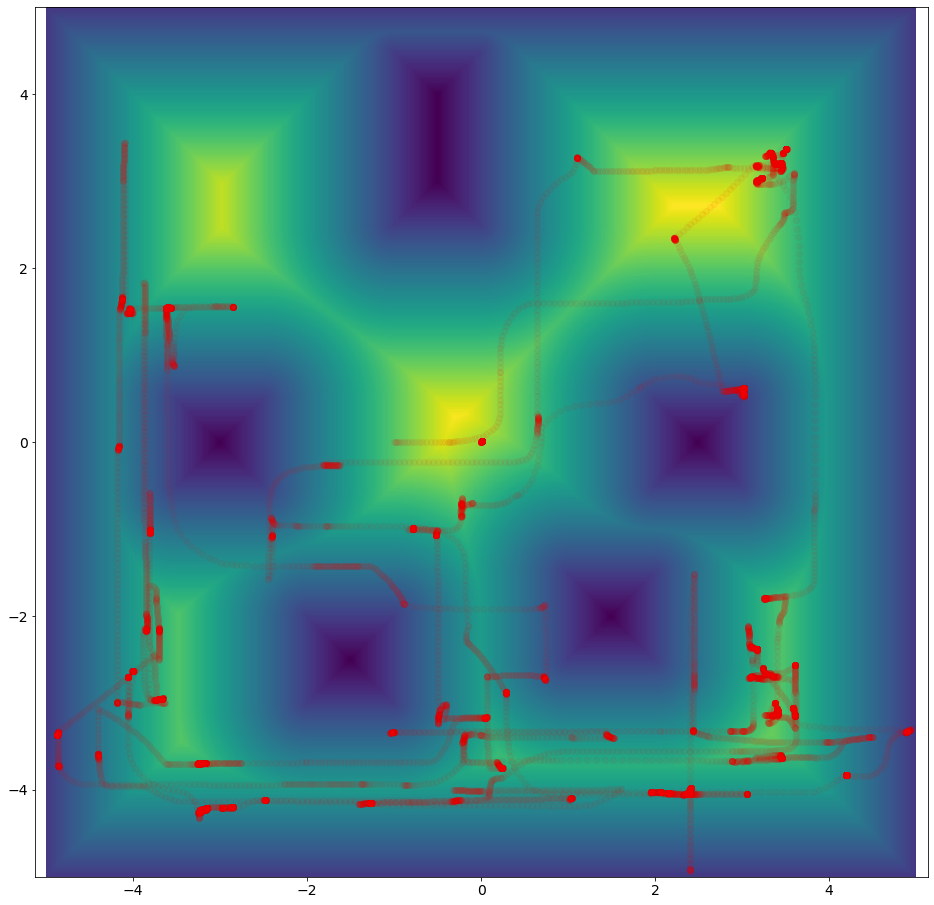

In [5]:
# show all location of the tail overlayed on the SDF
plt.figure(figsize=(16,16))
plt.imshow(np.flipud(sdf.T), extent=[-5,5,-5,5])
plt.scatter(tail[:,:,0], tail[:,:,1], c='r', alpha=0.05)
plt.axis("equal");

In [6]:
# iterate over the data and find the data points which are on the boundary of collision, and take their average
data_at_threshold = []
for state_traj, constraint_traj in zip(states, constraints):
    for t_idx in range(T - 1):
        current_constraint = constraint_traj[t_idx]
        next_constraint = constraint_traj[t_idx + 1]
        # xor operator
        if bool(current_constraint) ^ bool(next_constraint): 
            average_state = (state_traj[t_idx] + state_traj[t_idx + 1]) / 2
            data_at_threshold.append(average_state)
data_at_threshold = np.array(data_at_threshold)

In [7]:
threshold = 0.2
sdf_points_at_threshold = []
for row, col in np.ndindex(sdf.shape):
    d = sdf[row, col]
    if np.isclose(d, threshold):
        point = tpoc.sdf_idx_to_point(row, col, res, origin)
        sdf_points_at_threshold.append(point)
sdf_points_at_threshold = np.array(sdf_points_at_threshold).squeeze()
np.random.shuffle(sdf_points_at_threshold)

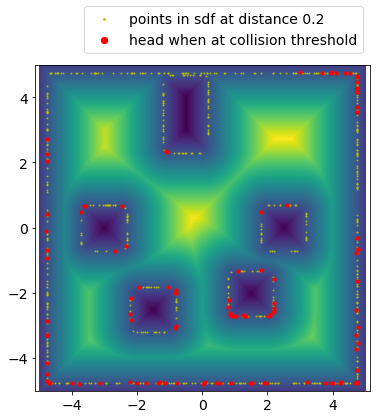

In [8]:
# show all location of the tail overlayed on the SDF
plt.figure(figsize=(6,6))
subsample = 10
plt.imshow(np.flipud(sdf.T), extent=[-5,5,-5,5])
plt.scatter(sdf_points_at_threshold[::subsample,0], sdf_points_at_threshold[::subsample,1], c='y', s=1, alpha=0.8, label='points in sdf at distance {}'.format(threshold))
plt.scatter(data_at_threshold[:,4], data_at_threshold[:,5], c='r', s=10, label='head when at collision threshold')
plt.legend(loc='upper right', bbox_to_anchor=(1.0,1.20))
plt.axis("equal");

# LM-ICP

We will solve the following optimization problem with LM


$$
R_j^*, j^* = \arg\min_{a,j} \sum_{i=1}^{N_d} \min_j||m_j - R_kd_i||^2_2
$$

Where we have a $N_d$ points (6D, rope configuration) $\{d_1, \dots, d_{N_d}\}$ and $N_m$ states $\{m_1, \dots, m_{N_m}\}$ (2D, at constraint boundary). We also have that $N_m>N_d$ The optimization variable $R_k$ is a matrix transforming a 6D point into 2D space.

In [9]:
from scipy.optimize import root
from scipy.spatial import cKDTree

In [72]:
kdtree = cKDTree(data=sdf_points_at_threshold)

def Rk(params):
    a1 = params[0]
    a2 = params[1]
    a3 = params[2]
    return np.array([
        [a1, 0],
        [0, a1],
        [a2, 0],
        [0, a2],
        [a3, 0],
        [0, a3],
    ])

def nn_correspondences(source, target):
    """
    source is a N_d by 2 matrix of points in R^2, which are the result of transforming data_at_threshold by R_k 
    target is a N_m by 2 matrix of points in R^2, which is sdf_points_at_threshold
    N_d < N_m
    the kdtree is build using the sdf points at threshold, of which there are more points.
    We will use the tree to find nearest points in the SDF to points from the rope data.
    """
    n_d = source.shape[0]
    n_m = target.shape[0]
    assert n_d < n_m, 'N_d {} must be < N_m {}'.format(n_d, n_m)
    distances, indeces = kdtree.query(source)
    return indeces
    
def func(params):
    R_k = Rk(params)
    transformed_data = data_at_threshold @ R_k
    correspondance_guess = nn_correspondences(transformed_data, sdf_points_at_threshold)
    corresponding_sdf_points = sdf_points_at_threshold[correspondance_guess]
    error = np.linalg.norm(corresponding_sdf_points - transformed_data, axis=1)
    return error

Solution: 
R_k:
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]]


In [103]:
initial_a = [0, 0, 1] + np.random.randn(3) * 0.1
initial_R_k = Rk(initial_a)
initial_transformed_data = data_at_threshold @ initial_R_k
initial_correspondance_guess = nn_correspondences(initial_transformed_data, sdf_points_at_threshold)
sol = root(func, initial_a, jac=None, method='lm')
if sol.success:
    print("Solution: ")
    print("R_k:")
    solution_R_k = Rk(sol.x)
    mean_error = np.mean(sol.fun)
    final_errors.append(mean_error)
    print(solution_R_k) 
    print("mean error: {:0.3f} m".format(mean_error))
else:
    print(sol.status)
    print(sol.message)
    print(sol.nit)

Solution: 
R_k:
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]]
mean error: 0.015 m


In [171]:
failures = 0
exact_solutions = 0
success_threshold = 0.02
n_runs = 1000
iterations = np.ndarray(n_runs)
final_errors = np.ndarray(n_runs)
for i in range(n_runs):
    initial_a = np.random.randn(3)
    initial_R_k = Rk(initial_a)
    initial_transformed_data = data_at_threshold @ initial_R_k
    initial_correspondance_guess = nn_correspondences(initial_transformed_data, sdf_points_at_threshold)
    sol = root(func, initial_a, jac=None, method='lm')
    if sol.success:
        mean_error = np.mean(sol.fun)
        final_errors[i] = mean_error
        if np.linalg.norm(sol.x - [0, 0, 1.0]) < 0.01:
            exact_solutions += 1
        iterations[i] = sol.nfev
    else:
        failures += 1
        
n_success = np.count_nonzero(final_errors < success_threshold)

print("# Failures: {}".format(failures))
print("Exact Solutions: {}".format(exact_solutions / n_runs * 100))
print("mean number of optimization iterations: {}".format(np.mean(iterations)))
print("median number of optimization iterations: {}".format(np.median(iterations)))
print("runs with less than {}m error {:4.1f}%".format(success_threshold, n_success / n_runs * 100))

# Failures: 0
Exact Solutions: 13.600000000000001
mean number of optimization iterations: 74.762
median number of optimization iterations: 70.0
runs with less than 0.02m error 13.6%


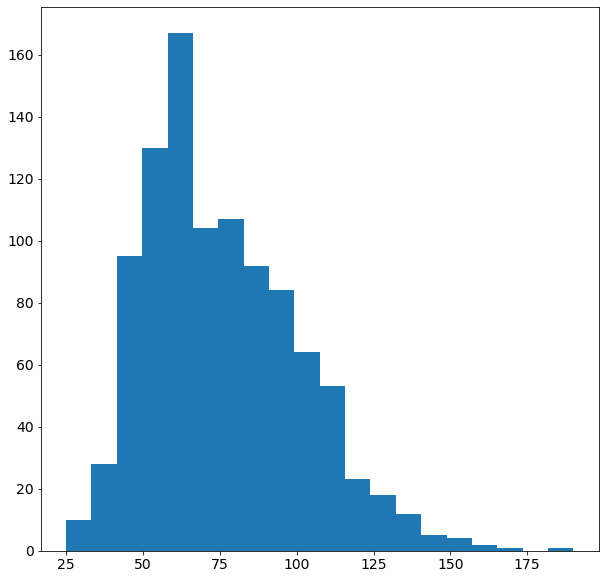

In [156]:
plt.figure(figsize=(10,10))
plt.hist(iterations, bins=20);

In [139]:
%timeit func(initial_a)

318 µs ± 2.95 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [172]:
success_threshold = 0.02
failures = 0
n_runs = 200
maxiter = 200
dts = np.ndarray(n_runs)
attempts = np.ndarray(n_runs)
for i in range(n_runs):
    t0 = time()
    attempt = 0
    while True:
        initial_a = np.random.randn(3)
        initial_R_k = Rk(initial_a)
        initial_transformed_data = data_at_threshold @ initial_R_k
        initial_correspondance_guess = nn_correspondences(initial_transformed_data, sdf_points_at_threshold)
        sol = root(func, initial_a, jac=None, method='lm')
        mean_error = np.mean(sol.fun)
        attempt += 1
        if mean_error < success_threshold:
            break
        if attempt > maxiter:
            failures += 1
            break
    dt = time() - t0
    dts[i] = dt
    attempts[i] = attempt
    
print("# Failures:", failures)
print("median dt: {:5.3f} seconds".format(np.median(dts)))
print("median attempts: {}".format(np.median(attempts)))

# Failures: 0
median dt: 0.093 seconds


In [173]:
attempts

array([ 4.,  1.,  4.,  2.,  2.,  5., 13.,  8.,  7., 23.,  6.,  2.,  2.,  3.,  9.,  1.,  6.,  1.,  1.,  4., 14.,  3., 13.,  4.,  5.,  1.,  6.,  1.,  9.,  9., 13.,  1.,  3., 26.,  7., 12., 15.,  7.,
        3., 10.,  2.,  2., 12., 16.,  2., 16.,  3.,  1.,  6., 18.,  5., 24.,  8., 26., 23.,  7.,  2.,  2.,  7.,  2., 18., 34.,  2.,  8.,  2.,  1., 18., 30., 13.,  7.,  1.,  4.,  6.,  1.,  4.,  5.,
        1.,  6.,  4.,  1.,  4.,  5.,  4.,  3.,  4.,  4., 28.,  4., 20.,  6.,  1.,  5.,  1.,  1., 10.,  3., 17.,  4.,  8.,  3.,  1., 17.,  3., 10.,  4.,  8., 10.,  3.,  1.,  5.,  2.,  5., 11.,  4.,
       10., 13.,  1.,  1.,  3.,  6.,  1.,  4.,  1.,  2., 11., 22., 12.,  2.,  4., 21.,  5.,  6.,  9.,  6.,  8.,  5.,  6.,  4.,  1.,  9.,  3.,  8., 11.,  8., 13.,  3., 11.,  8., 16.,  2.,  8.,  3.,
        1.,  6., 10.,  6.,  2.,  2.,  2.,  1., 18.,  1.,  2., 29.,  1., 11., 12.,  4.,  5.,  3.,  3.,  4., 13.,  2.,  3.,  5.,  8., 17., 25.,  1., 27., 12., 23., 24., 16.,  4.,  4.,  2., 11.,  6.,
        2., 26.

In [174]:
print("median attempts: {}".format(np.median(attempts)))

median attempts: 5.0
